## IMPORTING THE DATASET

In [1]:
import os
from pathlib import Path

base = Path('/kaggle/input')

for p in base.iterdir():
    print(p)

DATASET_DIR = Path('/kaggle/input/waste-classification-images/dataset') 

print("Dataset directory exists:", DATASET_DIR.exists())

/kaggle/input/waste-classification-images
Dataset directory exists: True


In [2]:
for sub in DATASET_DIR.iterdir():
    if sub.is_dir():
        print(sub.name, "->", len(list(sub.glob('*.*'))), "images")

1-Plastic -> 921 images
2-Paper -> 500 images
4-Food Organics -> 411 images
3-Metal -> 790 images


## DATA PREPROCESSING AND SPLITTING

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,  # 80% train, 20% validation
    subset="training",
    seed=123,  # for reproducibility
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 2622 files belonging to 4 classes.
Using 2098 files for training.
Found 2622 files belonging to 4 classes.
Using 524 files for validation.


In [28]:
class_names = train_ds.class_names
print("Class names:", class_names)

print("Training batches:", len(train_ds))
print("Validation batches:", len(val_ds))

Class names: ['1-Plastic', '2-Paper', '3-Metal', '4-Food Organics']
Training batches: 66
Validation batches: 17


### visualizing some images


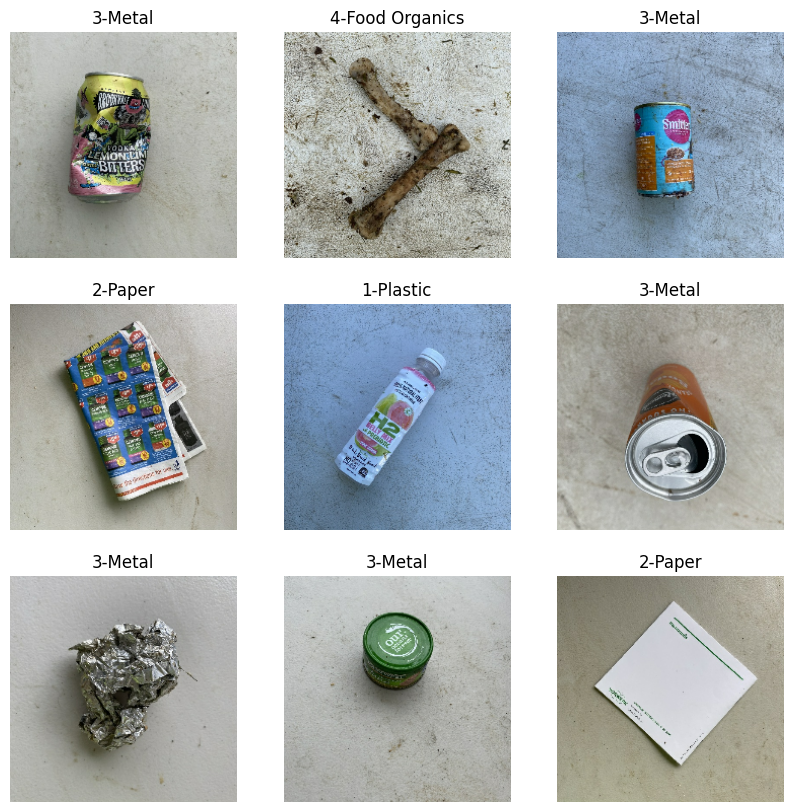

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [25]:
#for gpu caching
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### BUILDING THE MODEL

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import os

# reuse values from earlier
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = len(class_names)

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.12),
    layers.RandomZoom(0.12),
], name='data_augmentation')

# --- Build the model with transfer learning ---
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False  # freeze the base for initial training

# full model
inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation(inputs)               
x = tf.keras.applications.mobilenet_v2.preprocess_input(x) 
x = base_model(x, training=False)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,948 (9.87 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
#Callbacks (save best model, early stop)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/best_waste_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
earlystop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

callbacks = [checkpoint, earlystop, reduce_lr]

### Training - epochs

In [9]:
EPOCHS = 12
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/12


I0000 00:00:1762767339.661665     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6512 - loss: 0.8778
Epoch 1: val_accuracy improved from -inf to 0.87595, saving model to /kaggle/working/best_waste_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 110ms/step - accuracy: 0.6528 - loss: 0.8739 - val_accuracy: 0.8760 - val_loss: 0.3339 - learning_rate: 0.0010
Epoch 2/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8516 - loss: 0.3754
Epoch 2: val_accuracy improved from 0.87595 to 0.87977, saving model to /kaggle/working/best_waste_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.8517 - loss: 0.3751 - val_accuracy: 0.8798 - val_loss: 0.2978 - learning_rate: 0.0010
Epoch 3/12
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8828 - loss: 0.2758
Epoch 3: val_accuracy improved from 0.87977 to 0.90458, saving model to /kaggle/working/best_waste_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.8824 - loss: 0.2768 - val_accuracy: 0.9046 - val_loss: 0.2422 - learning_rate: 0.0010
Epoch 4/12
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8918 - loss: 0.2688
Epoch 4: val_accuracy did not improve from 0.90458
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.8919 - loss: 0.2691 - val_accuracy: 0.8702 - val_loss: 0.3075 - learning_rate: 0.0010
Epoch 5/12
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9119 - loss: 0.2170
Epoch 5: val_accuracy improved from 0.90458 to 0.91031, saving model to /kaggle/working/best_waste_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9117 - loss: 0.2176 - val_accuracy: 0.9103 - val_loss: 0.2387 - learning_rate: 0.0010
Epoch 6/12
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9211 - loss: 0.2088
Epoch 6: val_accuracy did not improve from 0.91031
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9207 - loss: 0.2094 - val_accuracy: 0.8950 - val_loss: 0.2691 - learning_rate: 0.0010
Epoch 7/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9127 - loss: 0.2080
Epoch 7: val_accuracy improved from 0.91031 to 0.91221, saving model to /kaggle/working/best_waste_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9127 - loss: 0.2082 - val_accuracy: 0.9122 - val_loss: 0.2499 - learning_rate: 0.0010
Epoch 8/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9141 - loss: 0.2149
Epoch 8: val_accuracy improved from 0.91221 to 0.92176, saving model to /kaggle/working/best_waste_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9143 - loss: 0.2146 - val_accuracy: 0.9218 - val_loss: 0.2255 - learning_rate: 0.0010
Epoch 9/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9117 - loss: 0.2094
Epoch 9: val_accuracy did not improve from 0.92176
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9119 - loss: 0.2091 - val_accuracy: 0.9122 - val_loss: 0.2276 - learning_rate: 0.0010
Epoch 10/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9267 - loss: 0.1811
Epoch 10: val_accuracy improved from 0.92176 to 0.92557, saving model to /kaggle/working/best_waste_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9268 - loss: 0.1809 - val_accuracy: 0.9256 - val_loss: 0.2266 - learning_rate: 0.0010
Epoch 11/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9411 - loss: 0.1479
Epoch 11: val_accuracy did not improve from 0.92557

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9410 - loss: 0.1482 - val_accuracy: 0.9103 - val_loss: 0.2329 - learning_rate: 0.0010
Epoch 12/12
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9397 - loss: 0.1468
Epoch 12: val_accuracy did not improve from 0.92557
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.9398 - loss: 0.1467 - val_accuracy: 0.9237 - val_loss: 0.2140 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 12.


## fine tuning

In [10]:
# Unfreeze the top layers of the base model
base_model.trainable = True

for layer in base_model.layers[:100]:
    layer.trainable = False

# Re-compile with a lower LR
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training for a few epochs
fine_tune_epochs = 8
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs,
    callbacks=callbacks
)

Epoch 1/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7781 - loss: 0.6428
Epoch 1: val_accuracy did not improve from 0.92557
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - accuracy: 0.7784 - loss: 0.6416 - val_accuracy: 0.9218 - val_loss: 0.2205 - learning_rate: 1.0000e-05
Epoch 2/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8629 - loss: 0.3825
Epoch 2: val_accuracy did not improve from 0.92557
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.8629 - loss: 0.3824 - val_accuracy: 0.9218 - val_loss: 0.2234 - learning_rate: 1.0000e-05
Epoch 3/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8910 - loss: 0.3170
Epoch 3: val_accuracy did not improve from 0.92557
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.8908 - loss: 0.3172 - val_accuracy: 0.9198 - val_loss: 0.2249 - learning_rate: 1.0000e-05
Epoch 4/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8841 - loss: 0.2757
Epoch 4: val_accuracy improved from 0.92557 to 0.92748, saving model to /kagg


Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.8842 - loss: 0.2758 - val_accuracy: 0.9275 - val_loss: 0.2224 - learning_rate: 1.0000e-05
Epoch 5/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9237 - loss: 0.2149
Epoch 5: val_accuracy did not improve from 0.92748
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.9237 - loss: 0.2150 - val_accuracy: 0.9275 - val_loss: 0.2220 - learning_rate: 5.0000e-06
Epoch 6/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9048 - loss: 0.2350
Epoch 6: val_accuracy did not improve from 0.92748
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.9048 - loss: 0.2350 - val_accuracy: 0.9275 - val_loss: 0.2226 - learning_rate: 5.0000e-06
Epoch 7/8
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9034 - loss: 0.2314
Epoch 7: val_accuracy did not improve from 0.92748

Epoch 7: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
66/66 

In [11]:
loss, acc = model.evaluate(val_ds)
print("Validation loss:", loss, "Validation accuracy:", acc)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9416 - loss: 0.1795
Validation loss: 0.22054550051689148 Validation accuracy: 0.9217557311058044


In [12]:
# save as HDF5
model.save('/kaggle/working/waste_classifier.h5')

## Class-wise metrics & confusion matrix

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step
                 precision    recall  f1-score   support

      1-Plastic     0.9337    0.8711    0.9013       194
        2-Paper     0.9263    0.9670    0.9462        91
        3-Metal     0.9030    0.9198    0.9113       162
4-Food Organics     0.9277    1.0000    0.9625        77

       accuracy                         0.9218       524
      macro avg     0.9227    0.9395    0.9303       524
   weighted avg     0.9221    0.9218    0.9212       524



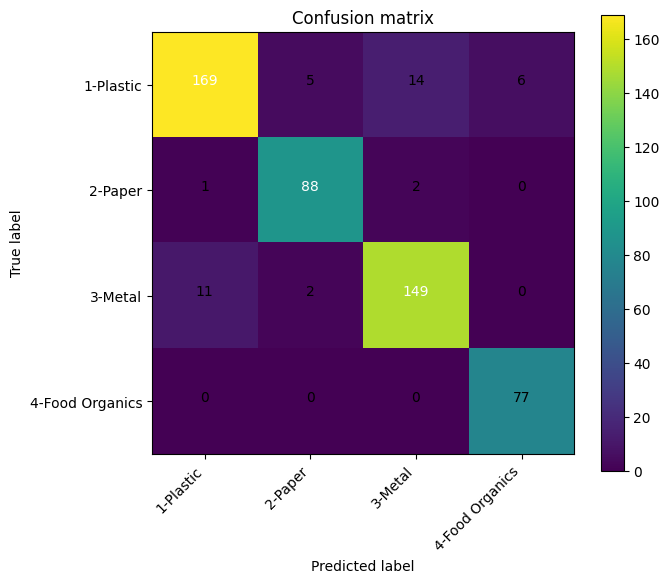

In [13]:
import numpy as np
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import itertools

# get predictions & true labels
y_true = np.concatenate([y.numpy() for x,y in val_ds], axis=0)
y_true = y_true.flatten()
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# classification report
print(skm.classification_report(y_true, y_pred, target_names=class_names, digits=4))

# confusion matrix
cm = skm.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


### sample prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


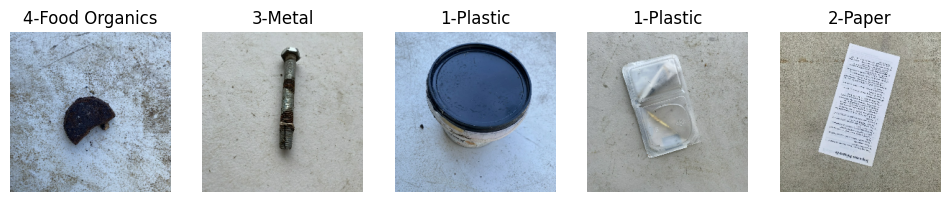

In [32]:
import numpy as np
import matplotlib.pyplot as plt

for images, labels in val_ds.take(1):
    preds = model.predict(images)
    predicted_labels = np.argmax(preds, axis=1)

    plt.figure(figsize=(12, 6))
    for i in range(5): 
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"{class_names[predicted_labels[i]]}")
        plt.axis("off")
    plt.show()